In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import os

from Software.GenuVP import runGNVP as gnvp

from PlaneDefinition.plane import Airplane as Plane
from PlaneDefinition.wing import Wing as wg
import PlaneDefinition.wing as wing

from Flight_Dynamics.disturbances import disturbance as disturb

from Database.getresults import Database_2D
from Database import DB3D , BASEGNVP

In [3]:
HOMEDIR = os.getcwd()

# Airfoil Data

In [4]:
db = Database_2D(HOMEDIR)
airfoils = db.getAirfoils()
polars2D = db.Data

# Get Plane

In [5]:
Origin = np.array([0., 0., 0.])

In [26]:
wingPos = np.array([0.0,0.0,0.0])
wingOrientation = np.array([2.8,0.0,0.0])

mainWing = wg(name="wing",
              airfoil=airfoils['NACA4415'],
              Origin=Origin + wingPos,
              Orientation=wingOrientation,           
              isSymmetric=True,
              span=2 * 1.130,
              sweepOffset=0,
              dihAngle=0,
              chordFun=wing.linearChord,
              chord=[0.159, 0.072],
              spanFun=wing.linSpan,
              N = 20,
              M = 5,
              mass = 0.670)
# mainWing.plotWing()

In [27]:
elevatorPos = np.array([0.54,0.,0.])
elevatorOrientantion = np.array([0.,0.,0.])

elevator = wg(name = "tail",
              airfoil=airfoils['NACA0008'],
              Origin=Origin+ elevatorPos,
              Orientation=elevatorOrientantion,
              isSymmetric=True,
              span= 2 * 0.169,
              sweepOffset=0,
              dihAngle=0,
              chordFun=wing.linearChord,
              chord=[0.130, 0.03],
              spanFun=wing.linSpan,
              N = 15,
              M = 5,
              mass = 0.06)
# elevator.plotWing()

In [28]:
rudderPos = np.array([0.47, 0., 0.01])
rudderOrientantion = np.array([0.0,0.0,90.0])

rudder = wg(name= "rudder",
            airfoil=airfoils['NACA0008'],
            Origin=Origin + rudderPos,
            Orientation= rudderOrientantion,
            isSymmetric=False,
            span= 0.160,
            sweepOffset=0.1,
            dihAngle=0,
            chordFun=wing.linearChord,
            chord=[0.2, 0.1],
            spanFun=wing.linSpan,
            N = 15,
            M = 5,
            mass = 0.04)
# rudder.plotWing()

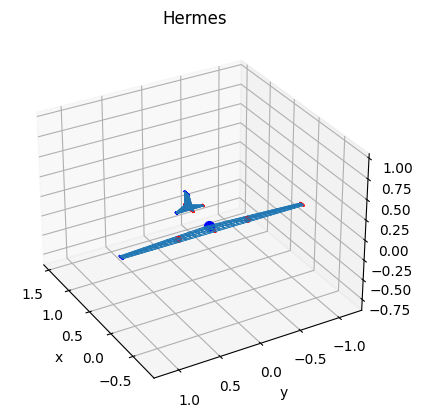

In [29]:
liftingSurfaces = [mainWing, elevator, rudder]
# liftingSurfaces = [rudder]
addedMasses = [
    (0.500 , np.array([-0.40, 0.0, 0.0])), # Motor
    (1.000 , np.array([0.090, 0.0, 0.0])), # Battery
    (0.900 , np.array([0.130, 0.0, 0.0])), # Payload
    ]
ap = Plane("Hermes", liftingSurfaces)
ap.accessDB(HOMEDIR, DB3D)
ap.visAirplane()
ap.addMasses(addedMasses)

In [30]:
cleaning = False
calcGenu = True
calcBatchGenu = True
petrubationAnalysis = True
sensitivityAnalysis = True

## AoA Run

In [31]:
AoAmax = 10
AoAmin = -6
NoAoA = (AoAmax - AoAmin) + 1
angles = np.linspace(AoAmin, AoAmax, NoAoA)

Uinf = 20
maxiter = 50
timestep = 5e-2

In [32]:
ap.CASEDIR

'/home/tryfonas/data/Uni/Software/hermes/Database/3D/Hermes'

In [33]:
if calcBatchGenu == True:
    genuBatchArgs = [ap, BASEGNVP, polars2D,"Xfoil",
                     maxiter,timestep,Uinf, angles]
    ap.runSolver(gnvp.runGNVPangles,genuBatchArgs)
genuPolarArgs = [ap.CASEDIR, HOMEDIR]
ap.makePolars(gnvp.makePolar,genuPolarArgs)
ap.defineSim(Uinf, 1.225)
ap.save()


Running Angles -6.0
'/home/tryfonas/data/Uni/Software/hermes/Database/3D/Hermes/m6.0000_AoA//gnvp' -> '/home/tryfonas/data/Uni/Software/hermes/gnvp'
Running Angles -5.0
'/home/tryfonas/data/Uni/Software/hermes/Database/3D/Hermes/m5.0000_AoA//gnvp' -> '/home/tryfonas/data/Uni/Software/hermes/gnvp'
Running Angles -4.0
'/home/tryfonas/data/Uni/Software/hermes/Database/3D/Hermes/m4.0000_AoA//gnvp' -> '/home/tryfonas/data/Uni/Software/hermes/gnvp'
Running Angles -3.0
'/home/tryfonas/data/Uni/Software/hermes/Database/3D/Hermes/m3.0000_AoA//gnvp' -> '/home/tryfonas/data/Uni/Software/hermes/gnvp'
Running Angles -2.0
'/home/tryfonas/data/Uni/Software/hermes/Database/3D/Hermes/m2.0000_AoA//gnvp' -> '/home/tryfonas/data/Uni/Software/hermes/gnvp'
Running Angles -1.0
'/home/tryfonas/data/Uni/Software/hermes/Database/3D/Hermes/m1.0000_AoA//gnvp' -> '/home/tryfonas/data/Uni/Software/hermes/gnvp'
Running Angles 0.0
'/home/tryfonas/data/Uni/Software/hermes/Database/3D/Hermes/0.00000_AoA//gnvp' -> '/hom

# Dynamics

In [34]:
from Flight_Dynamics.dyn_plane import dyn_plane as dp

### Define and Trim Plane

In [35]:
dyn = dp(ap,polars2D)

Using 2D polar for dynamic analysis
Cm is 0.025641167760428088 instead of 0 at AoA = -5.0
Interpolated values are: AoA = -4.643327668524176 , Cm = -6.938893903907228e-18, Cl = 0.16300949517633898
Trim velocity is 34.54295011113518 m/s


### Pertrubations

In [15]:
dyn.allPerturb("Central")
dyn.disturbances = [dyn.disturbances[-1]]
dyn.get_pertrub()

Trim: 
	Type:		None
	Amplitude:	None.


In [16]:
if petrubationAnalysis == True:
    genuBatchArgs = [dyn, BASEGNVP, polars2D,"Xfoil",
                     maxiter, timestep,
                     dyn.trim['U'], dyn.trim['AoA']]
    dyn.accessDB(HOMEDIR)
    dyn.runAnalysis(gnvp.runGNVPpertr,genuBatchArgs)
genuLogArgs = [dyn.DynDir, HOMEDIR]
dyn.logResults(gnvp.logResults,genuLogArgs)
dyn.save()

Running Case Trim - None
'/home/tryfonas/data/Uni/Software/hermes/Database/3D/HermesFASTPLANE/Dynamics/Trim///gnvp' -> '/home/tryfonas/data/Uni/Software/hermes/gnvp'
Logging Pertrubations


forrtl: severe (194): Run-Time Check Failure. The variable 'clcdcm_curv_$JJ' is being used in 'rescpv-3.f(2126,27)' without being defined
Image              PC                Routine            Line        Source             
gnvp               000000000046DE0F  local_aero_param_        2262  rescpv-3.f
gnvp               0000000000469B09  strip_calc_               545  rescpv-3.f
gnvp               0000000000467ADE  rescpv_                    51  rescpv-3.f
gnvp               00000000004B5193  MAIN__                    250  gnvp-3.f
gnvp               00000000004041DD  Unknown               Unknown  Unknown
libc.so.6          00007F5F569EF510  Unknown               Unknown  Unknown
libc.so.6          00007F5F569EF5C9  __libc_start_main     Unknown  Unknown
gnvp               00000000004040F5  Unknown               Unknown  Unknown


In [17]:
if sensitivityAnalysis == True:
    for var in ['u','w','q','theta','v','p','r','phi']:
        space = np.logspace(np.log10(0.00001), np.log10(1), 10, base=10)
        space =[*-space,*space]

        dyn.sensitivityAnalysis(var, space)
        genuBatchArgs = [dyn, var, BASEGNVP, polars2D, "Xfoil",
                        maxiter, timestep,
                        dyn.trim['U'], dyn.trim['AoA']]
        # dyn.runAnalysis(gnvp.runGNVPsensitivity, genuBatchArgs)
        dyn.sensResults[var] = gnvp.logResults(
            f"{dyn.CASEDIR}/Sensitivity_{var}", HOMEDIR)
    dyn.save()

FileNotFoundError: [Errno 2] No such file or directory: '/home/tryfonas/data/Uni/Software/hermes/Database/3D/HermesFASTPLANE/Sensitivity_u'

In [ ]:
dyn.trim

{'U': 27.97781124296061, 'AoA': -3.660212318003781}

In [ ]:
dyn.scheme = "Backward"
dyn.longitudalStability('2D')
dyn.lateralStability('Potential')

u 0.053122282 0.051188946
q 0.053122282 0.058478355
w 0.053122282 0.027635694
theta 0.053122282 0.069507837
Longitudal Derivatives
Xu=	-0.004983291800941814		Cxu=	-1.2561256042848286e-05
Xw=	1.1083767469799		Cxa=	-0.07822728121640889
Zu=	-5.35824793457742		Czu=	-0.013506398367956187
Zw=	-26.71764088438877		CLa=	-7.428397210297401
Zq=	-6.274520701538892		CLq=	-0.05013679503388054
Mu=	0.19333360000000008		Cmu=	0.012772977824959716
Mw=	2.5486588		Cma=	6.202526219726602
Mq=	1.227521510655894		Cmq=	0.08109870728765606

Lateral Derivatives
Yv=	-1.0389065789999998
Yp=	-0.047139390751623815
Yr=	-0.6366256880931541
Lv=	0.024907130760923487
Lp=	-8.361726342605861
Lr=	1.550044021180412
Nv=	-0.5805959299057173
Np=	-0.4294208433952166
Nr=	-0.33827285260105755


In [ ]:
    #   Longitudinal derivatives
    #   Xu=    -0.16379         Cxu=   -0.049477
    #   Xw=      1.1494         Cxa=     0.34723
    #   Zu=     -3.0117         Czu=  -0.0035415
    #   Zw=     -19.528         CLa=      5.8991
    #   Zq=     -1.8321         CLq=      9.1645
    #   Mu= -0.00060463         Cmu=  -0.0015122
    #   Mw=    -0.45664         Cma=     -1.1421
    #   Mq=    -0.39098         Cmq=     -16.193

    #   Lateral derivatives
    #   Yv=     -0.5496         CYb=    -0.16602
    #   Yp=   -0.017022         CYp=  -0.0045504
    #   Yr=     0.32383         CYr=    0.086568
    #   Lv=    0.039731         Clb=   0.0053106
    #   Lp=     -5.6227         Clp=     -0.6651
    #   Lr=      1.0377         Clr=     0.12275
    #   Nv=     0.28879         Cnb=    0.038602
    #   Np=    -0.57586         Cnp=   -0.068117
    #   Nr=     -0.1259         Cnr=   -0.014893

In [ ]:
print(dyn.Along)
# [xu, xw, xq, xth]
# [zu, zw, zq, zth]
# [mu, mw, mq, mth]
# [0,  1 , 0 ,  0 ]

# Eigenvalue:  -4.524 + -8.045i | -4.524 + 8.045i           | -0.01025 + -0.602i        |-0.01025 + 0.602i
#   _____________________________________________________________________________________________________
# Eigenvector:           1 + 0i | 1 + 0i                    | 1 + 0i                   | 1 + 0i
         #      25.53 + -19.47i | 25.53 + 19.47i            | -0.03335 + 0.004629i     | -0.03335+-0.004629i
      #     -5.653+   -11.77i   |      -5.653+    11.77i    |      0.0371+ 0.002409i   |      0.0371+-0.002409i
      #      1.412+  0.09123i   |       1.412+ -0.09123i    |   -0.005049+  0.06154i   |   -0.005049+ -0.06154i
# dyn.AstarLong

print("\n\nEIGENVALUES:")
np.linalg.eig(dyn.Along)

eigvalLong, eigvecLong = np.linalg.eig(dyn.Along)
print(eigvalLong)


[[-1.73955632e-02  3.50952257e-01 -1.79622423e+00 -9.78998947e+00]
 [-1.41467442e+00 -8.57290589e+00  2.74023629e+01  6.26263672e-01]
 [ 1.55876545e+00  1.91267902e+01  5.07806704e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]]


EIGENVALUES:
[-25.5401297 +0.j          22.11556705+0.j
  -0.04383588+0.48623339j  -0.04383588-0.48623339j]


In [ ]:
print(dyn.Alat)
# [yv, yp , yr, yphi]
# [lv, lp , lr, lphi]
# [nv, n_p, nr, nph ]
# [0 , 1  , 0 , 0   ]

# XFLR5
# -0.173375         -0.00536967              -20.63                9.81
#  0.243269             -30.274             5.56351                   0
#  0.902122            -2.37023            -0.28454                   0
#         0                   1                   0                   0

# dyn.AstarLat

print("\n\nEIGENVALUES:")
eigvalLat, eigvecLat =  np.linalg.eig(dyn.Alat)
print(eigvalLat)

[[ -0.3238939   -1.79293845 -28.11594498   9.78998947]
 [  0.11204023 -45.02688457   8.30518725   0.        ]
 [ -1.78110519  -1.54255932  -0.97335517   0.        ]
 [  0.           1.           0.           0.        ]]


EIGENVALUES:
[-44.702631    -8.01373729   6.32883076   0.06340389]


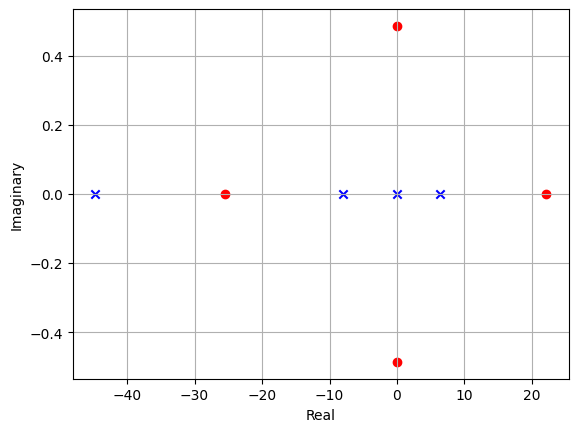

In [ ]:
# plot the complex numbers
import matplotlib.pyplot as plt 

# extract real part
x = [ele.real for ele in eigvalLong]
# extract imaginary part
y=[ele.imag for ele in eigvalLong]
plt.scatter(x, y, color = "r")

# extract real part
x = [ele.real for ele in eigvalLat]
# extract imaginary part
y = [ele.imag for ele in eigvalLat]
plt.scatter(x, y, color="b",marker = 'x')

plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.grid()
plt.show()

Running Angles -6.0
'/home/tryfonas/data/Uni/Software/hermes/Database/3D/Hermes2/m6.0000_AoA//gnvp' -> '/home/tryfonas/data/Uni/Software/hermes/gnvp'
Running Angles -5.0
'/home/tryfonas/data/Uni/Software/hermes/Database/3D/Hermes2/m5.0000_AoA//gnvp' -> '/home/tryfonas/data/Uni/Software/hermes/gnvp'
Running Angles -4.0
'/home/tryfonas/data/Uni/Software/hermes/Database/3D/Hermes2/m4.0000_AoA//gnvp' -> '/home/tryfonas/data/Uni/Software/hermes/gnvp'
Running Angles -3.0
'/home/tryfonas/data/Uni/Software/hermes/Database/3D/Hermes2/m3.0000_AoA//gnvp' -> '/home/tryfonas/data/Uni/Software/hermes/gnvp'
Running Angles -2.0
'/home/tryfonas/data/Uni/Software/hermes/Database/3D/Hermes2/m2.0000_AoA//gnvp' -> '/home/tryfonas/data/Uni/Software/hermes/gnvp'
Running Angles -1.0
'/home/tryfonas/data/Uni/Software/hermes/Database/3D/Hermes2/m1.0000_AoA//gnvp' -> '/home/tryfonas/data/Uni/Software/hermes/gnvp'
Running Angles 0.0
'/home/tryfonas/data/Uni/Software/hermes/Database/3D/Hermes2/0.00000_AoA//gnvp' -

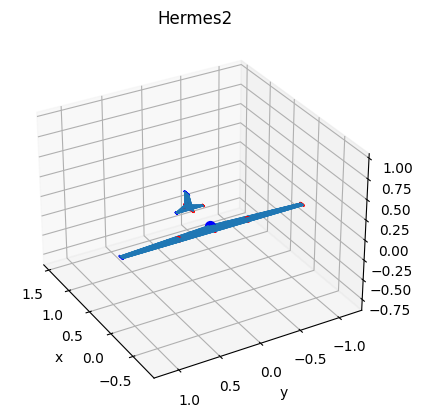

In [ ]:
liftingSurfaces = [mainWing, elevator, rudder]
# liftingSurfaces = [rudder]
addedMasses = [
    (0.500, np.array([-0.40, 0.0, 0.0])),  # Motor
    (1.000, np.array([0.090, 0.0, 0.0])),  # Battery
    (0.900, np.array([0.130, 0.0, 0.0])),  # Payload
]
ap = Plane("Hermes2", liftingSurfaces)
ap.accessDB(HOMEDIR, DB3D)
ap.visAirplane()
ap.addMasses(addedMasses)

AoAmax = 10
AoAmin = -6
NoAoA = (AoAmax - AoAmin) + 1
angles = np.linspace(AoAmin, AoAmax, NoAoA)

Uinf = 20
maxiter = 70
timestep = 1e-1


if calcBatchGenu == True:
    genuBatchArgs = [ap, BASEGNVP, polars2D, "Xfoil",
                     maxiter, timestep, Uinf, angles]
    ap.runSolver(gnvp.runGNVPangles, genuBatchArgs)
genuPolarArgs = [ap.CASEDIR, HOMEDIR]
ap.makePolars(gnvp.makePolar, genuPolarArgs)
ap.defineSim(Uinf, 1.225)
ap.save()
